<center>

*******************************************************************************************
    
### Recurrence of Chord Roots
### in Audio File      
<br>
  
##### 5 December 2024

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

#### INFORMATION:

* Description:
    * Find the roots of chords.
    * Find recurring sequences of chord roots.
    
    <br>
* References:
    * https://librosa.org/doc/latest/index.html
    * McFee et al. (2015) librosa: Audio and Music Signal Analysis in Python. In _Proceedings of the 14th Python in Science conference_, pp. 18-25. 
    
    <br>
* Instructions:

    Edit the values indicated with an arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.  

*******************************************************************************************


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as sgnl
import IPython.display as ipd
import librosa  

## Load and Inspect Data

In [14]:
audio_folder = r"C:\Users\Arthur_Dent\Documents\Heart_of_Gold\Audio" # <--- full path to folder with audio file without ending backslash
audio_fn = 'Pachelbel_Canon_in_D_String_Quartet.aac' # <--- audio file name (with extension)

In [ ]:
# open audio file:

full_fn = audio_folder+'\\'+ audio_fn
y, sr = librosa.load(full_fn)
# ipd.Audio(y, rate=sr) # uncomment to play audio, but the notebook's size will greatly increase

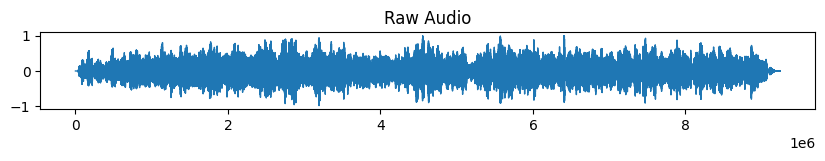

In [16]:
pd.Series(y).plot(figsize=(10, 1), lw=1, title='Raw Audio')
plt.show()

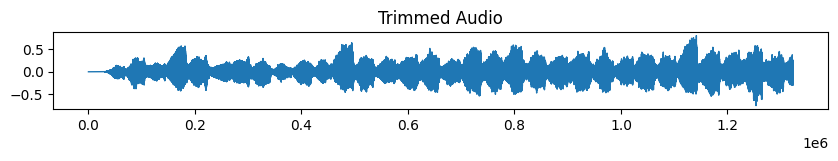

In [17]:
# Trim:

trim = [0,60] # <--- [start,end] in seconds or 'end', '' or [] = no trim

if not trim or ((trim[0] == 0) & (trim[1] == 'end')): y_trimmed = y
else: 
    trim_start = trim[0]*sr
    if trim[1] == 'end': trim_end = y.shape[0]*sr
    else: trim_end = trim[1]*sr
    y_trimmed = y[trim_start:trim_end]

pd.Series(y_trimmed).plot(figsize=(10, 1), lw=1, title='Trimmed Audio')
plt.show()

***
## Chromagram segmentation

In [18]:
feat_chroma = librosa.feature.chroma_cens(y=y_trimmed, sr=sr)

f_cutoff = 500 # <--- low-pass cutoff frequency
b, a = sgnl.butter(1, f_cutoff, 'low', fs=sr)
feat_chroma_s = feat_chroma.copy()
for i in range(feat_chroma.shape[0]):
    feat_chroma_s[i,:] = sgnl.filtfilt(b, a, feat_chroma[i,:])
onset_env = np.sum(feat_chroma_s,axis=0)

pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)
beats_plp = np.flatnonzero(librosa.util.localmax(pulse))
beat_times = librosa.frames_to_time(beats_plp, sr=sr, hop_length=512)

note_classes_str = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B']

In [19]:
def display_results(arg_1,arg_2):
    '''
    ALL MODES: Display chromagram with harmonic segments' boundaries overlaid. 
    MODE 1: Print list of the strongest note in each segment.
        Argument 1: 'all'
        Argument 2: anything (not used)
    MODE 2: Overlay a rectangle highlighting the section.
        Argument 1: index of the first segment (number, not time);
        Argument 2: length of the section (number of segments);
                    if argument 2 = 1: Also Display the note-class strength of segment.
    MODE 3: Overlay boundaries.
        Argument 1: list or array of time-stamps.
        Argument 2: colour for lines.
    '''
    if isinstance(arg_1,str) and arg_1 == 'all':
        idx_segm = range(beats_plp.shape[0])
    elif isinstance(arg_1,int):
        if arg_2 == 1:
            idx_segm = [arg_1]
        elif arg_2 > 1:
            idx_segm = range(arg_1,arg_1+arg_2,1)
        else:
            raise Exception("'length' (second argument) should be an integer greater than zero")
    elif isinstance(arg_1, list) or isinstance(arg_1, np.ndarray):
        idx_segm = []
    else:
        raise Exception("'index' (first argument) should be an integer (including zero) or 'all' or a list or an ndarray")
    strongest_notes = []
    for i_segm in idx_segm: 
        if i_segm == 0: seg_start = 0
        else: seg_start = beats_plp[i_segm-1:i_segm][0]
        seg_end = beats_plp[i_segm:i_segm+1][0]
    
        this_seg = np.sum( feat_chroma[:,seg_start:seg_end] , axis=1 )**2
        this_note = note_classes_str[np.argmax(this_seg)]
        strongest_notes.append(this_note)

    if isinstance(arg_1,int) & (arg_2 == 1):
        x_ticks = range(this_seg.shape[0])
        fig, ax = plt.subplots(figsize=(5,1))
        ax.bar(x_ticks,this_seg.T);
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(note_classes_str)
        ax.set_title('Note-class Strength')

    fig, ax = plt.subplots(figsize =(10,2))
    librosa.display.specshow(feat_chroma,y_axis='chroma', x_axis='time', ax=ax)
    lims = ax.get_ylim()
    ax.vlines(beat_times, lims[0], lims[1], color='lime', alpha=0.8, linewidth=2, label='Beats')
    ax.set(title='Segmented Chroma')

    if isinstance(arg_1,int):
        if idx_segm[0] == 0: 
            seg_start_t = 0
        else: 
            seg_start_t = beat_times[idx_segm[0]-1]
        seg_end_t = beat_times[idx_segm[-1]]
        highlight_box = plt.Rectangle(xy=(seg_start_t,-0.45), width=seg_end_t-seg_start_t, height=lims[1]+0.3, 
                                      fill=False, edgecolor=(1,1,1,1), linewidth=4, linestyle=':',zorder=2)
        ax.add_patch(highlight_box)
    lbl = 'strongest notes'
    if len(strongest_notes) == 1:
        strongest_notes = strongest_notes[0]
        lbl = lbl[:-1]
    if not idx_segm:
        plt.vlines(x = arg_1, ymin=lims[0], ymax=lims[1], colors = arg_2, linestyles=':',linewidths=4)
    else:
        print( lbl+':',strongest_notes ) 

#### Visualise note-class strength:
Notice that the strongest note is not always the root of the chord.\
In the example below, chord 14 is D, as it strongest notes are D (root), F# (major third), and A (fifth).
However, the root is not the strongest note.

strongest note: A


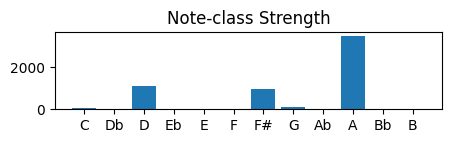

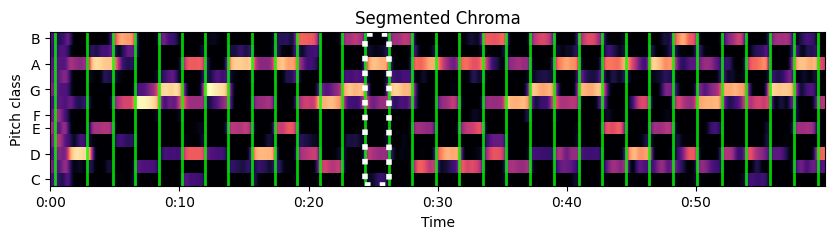

In [20]:
# get_result = 'all' # <--- segment index or 'all'
get_result = 14 # <--- segment index or 'all'

display_results(get_result,1)

***
## Root detection

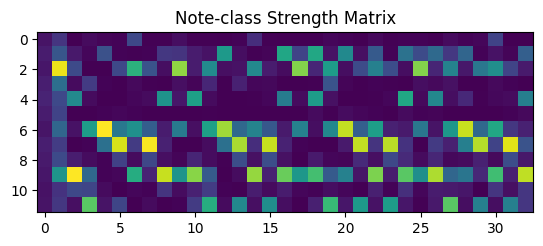

In [21]:
# Reduce to a matrix where each column is a segment:

note_strength_matrix = np.empty((12,beats_plp.shape[0]))
for i_segm in range(beats_plp.shape[0]): 
    if i_segm == 0: seg_start = 0
    else: seg_start = beats_plp[i_segm-1:i_segm][0]
    seg_end = beats_plp[i_segm:i_segm+1][0]
    
    note_strength_matrix[:,i_segm] = np.sum( feat_chroma[:,seg_start:seg_end] , axis=1 )#**2
plt.imshow(note_strength_matrix)
plt.title('Note-class Strength Matrix');

In [22]:
def detect_roots(note_strengths):
    '''
    INPUT: array of note-strengths [rows,colums] = [note classes,segments]
    OUTPUT: list of detected roots for each segment
    '''
    roots_lst = []
    for i_segm in range(note_strengths.shape[1]):
        i_sorted_classes = np.argsort(note_strengths[:,i_segm])[::-1] 
        
        diff_two = i_sorted_classes[1] - i_sorted_classes[0]
        diff_three = []
        # root and fifth:
        if diff_two == 7: # root position: root is lowest and strongest
            this_root = i_sorted_classes[0]
        elif diff_two == -7: # root position: root is lowest, fifth is strongest
            this_root = i_sorted_classes[1]  
        elif diff_two == -5: # 2nd inversion: fifth is lowest, root is strongest
            this_root = i_sorted_classes[0]
        else:
            # root, third, fifth:
            diff_three = np.diff(i_sorted_classes[0:3]).tolist()
            if diff_three == [-3,-4]: # root position: root, third, fifth; strength: fifth, third, root
                this_root = i_sorted_classes[2]
            else:
                this_root = i_sorted_classes[0]
        roots_lst.append(this_root)    
    return roots_lst

roots: ['G', 'D', 'G']
strongest notes: ['G', 'A', 'G']


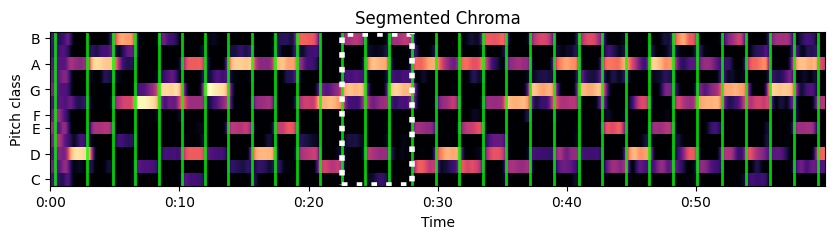

In [23]:
# Detect roots of a section:

i_sec = 13 # <--- starting segment of section to analyse
length_sec = 3 # <--- length of section to analyse

detected_roots = [note_classes_str[i] for i in detect_roots( note_strength_matrix[:,i_sec:i_sec+length_sec] )]
roots_lbl = 'roots'
if len(detected_roots) == 1: 
    detected_roots = detected_roots[0]
    roots_lbl = roots_lbl[:-1]
print(roots_lbl +':',detected_roots)

display_results(i_sec,length_sec)

***
## Find sections with recurrent patterns

All roots:
 ['E', 'D', 'A', 'B', 'F#', 'G', 'D', 'G', 'A', 'D', 'A', 'B', 'F#', 'G', 'D', 'G', 'A', 'D', 'A', 'B', 'F#', 'G', 'D', 'G', 'A', 'D', 'A', 'B', 'F#', 'G', 'D', 'G', 'A'] 

Recurrent root patterns:
['D', 'A', 'B', 'F#', 'G', 'D', 'G', 'A']
['D', 'A', 'B', 'F#', 'G', 'D', 'G', 'A', 'D', 'A', 'B', 'F#', 'G', 'D', 'G', 'A']

Index of sections with recurrent patterns:
 [1, 9, 17, 25, 33]


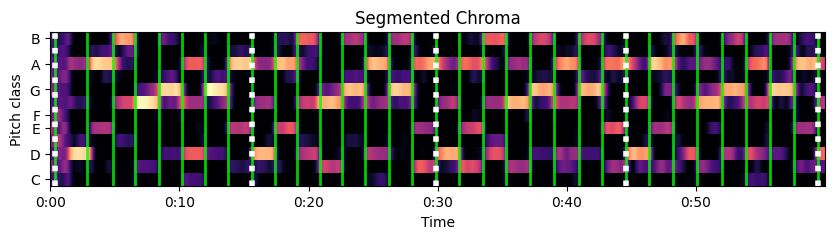

In [37]:
all_roots_int = detect_roots(note_strength_matrix)
all_roots_str = [note_classes_str[i] for i in all_roots_int]
print('All roots:\n',all_roots_str,'\n')

# Find recurrent sequences:
n_n_minmax = [2,len(all_roots_str)] # [minimum, maximum] length (number of notes) of sequences
i_sec_rec_patt = []
recurrent_patterns = []
for n_n in range(n_n_minmax[0],n_n_minmax[1]+1):
    
    i_start_this = 0
    i_end_next = 0
    while i_start_this < len(all_roots_str):
    
        i_end_this = i_start_this + n_n
        this_sequence = all_roots_str[i_start_this:i_end_this]
        i_end_next = i_end_this + n_n
        next_sequence = all_roots_str[i_end_this:i_end_next ]
        if this_sequence == next_sequence:
            i_sec_rec_patt = i_sec_rec_patt + [i_start_this,i_end_this,i_end_next]
            if this_sequence not in recurrent_patterns:
                recurrent_patterns.append(this_sequence)            
            i_start_this = i_end_this
        else:
            i_start_this += 1

print('Recurrent root patterns:')
for patt in recurrent_patterns: print(patt)

i_sec_rec_patt = list(dict.fromkeys(i_sec_rec_patt)) # segments at the boundaries of recurrent sections
print('\nIndex of sections with recurrent patterns:\n',i_sec_rec_patt)

ts_sec_rec_patt = beat_times[[v-1 for v in i_sec_rec_patt]] # time-stamps of recurrent sections' boundaries
display_results( ts_sec_rec_patt , 'w')